Class Distribution:
3    340066
2     14596
0     10049
4      6638
1      3312
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.8350 - loss: 0.4056 - val_accuracy: 0.9000 - val_loss: 0.2046
Epoch 2/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 164s 4ms/step - accuracy: 0.8967 - loss: 0.2157 - val_accuracy: 0.9033 - val_loss: 0.1920
Epoch 3/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.9011 - loss: 0.2037 - val_accuracy: 0.9045 - val_loss: 0.1882
Epoch 4/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 168s 5ms/step - accuracy: 0.9049 - loss: 0.1977 - val_accuracy: 0.9261 - val_loss: 0.1818
Epoch 5/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 199s 4ms/step - accuracy: 0.9092 - loss: 0.1921 - val_accuracy: 0.9290 - val_loss: 0.1723
Epoch 6/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 163s 4ms/step - accuracy: 0.9180 - loss: 0.1838 - val_accuracy: 0.9402 - val_loss: 0.1559
Epoch 7/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 207s 5ms/step - accuracy: 0.9289 - loss: 0.1717 - val_accuracy: 0.9448 - val_loss: 0.1445
Epoch 8/10
37195/37195 ━━━━━━━━━━━━━━━━━━━━ 216s 5ms/step - ac

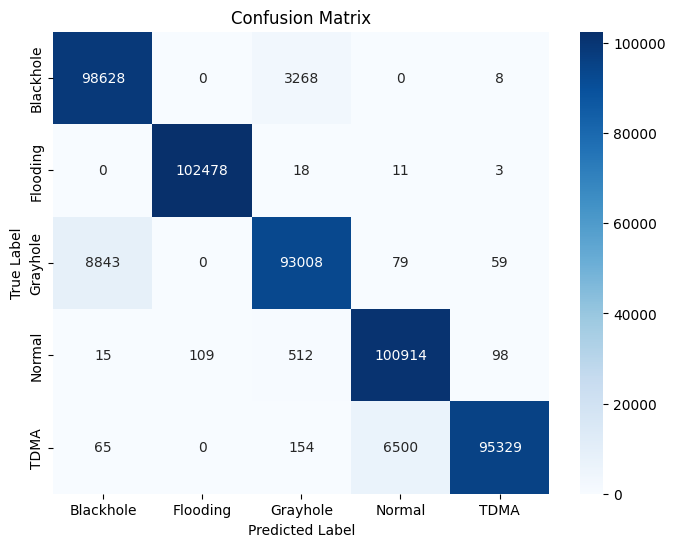

Classification Report:
              precision    recall  f1-score   support

   Blackhole       0.92      0.97      0.94    101904
    Flooding       1.00      1.00      1.00    102510
    Grayhole       0.96      0.91      0.93    101989
      Normal       0.94      0.99      0.96    101648
        TDMA       1.00      0.93      0.97    102048

    accuracy                           0.96    510099
   macro avg       0.96      0.96      0.96    510099
weighted avg       0.96      0.96      0.96    510099



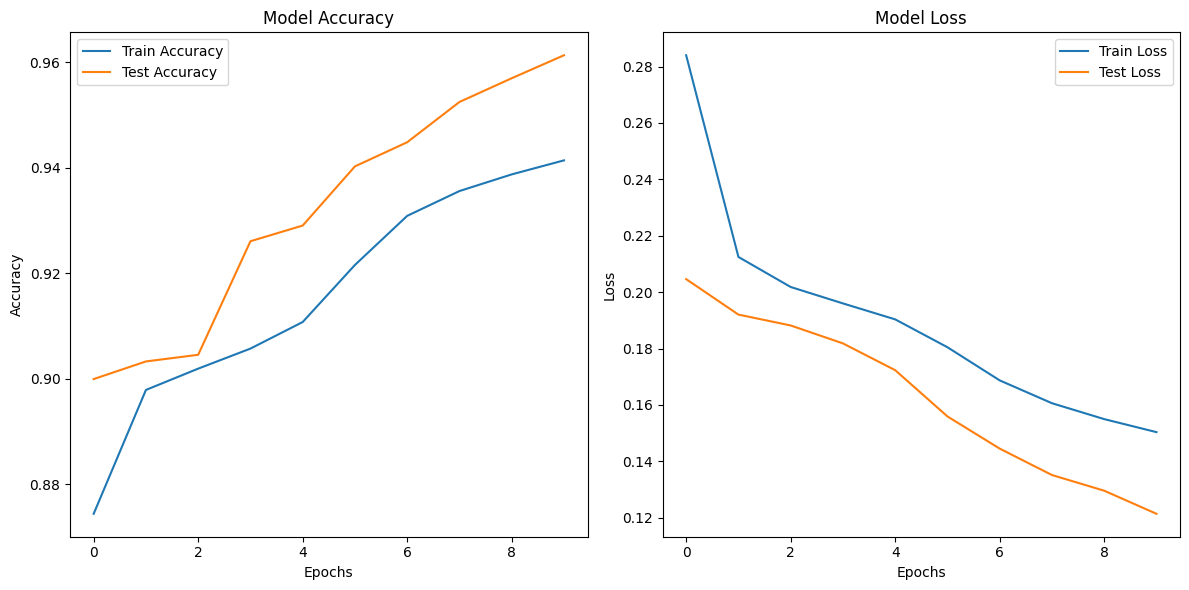

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score # Import accuracy_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical


# Load dataset
data = pd.read_csv('/content/WSN-DS.csv')
data.columns = data.columns.str.strip()  # Clean column names

# Separate features (X) and labels (y)
X = data.drop('Attack type', axis=1)
y = data['Attack type']*/

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Replace infinite values and fill NaN values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Check class distribution to understand imbalance
print("Class Distribution:")
print(pd.Series(y).value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.9)  # Retain 90% of variance
X_pca = pca.fit_transform(X_resampled)

# Convert labels to one-hot encoding for multi-class classification
num_classes = len(np.unique(y_resampled))
y_resampled_one_hot = to_categorical(y_resampled, num_classes=num_classes)


X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled_one_hot, test_size=0.3, random_state=42)

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Print classification metrics
accuracy = accuracy_score(y_test_labels, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print(conf_matrix)

# Plot Confusion Matrix for Multi-Class Classification
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58539 entries, 0 to 58538
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0    id               58539 non-null  int64  
 1    Time             58539 non-null  int64  
 2    Is_CH            58539 non-null  int64  
 3    who CH           58539 non-null  int64  
 4    Dist_To_CH       58539 non-null  float64
 5    ADV_S            58539 non-null  int64  
 6    ADV_R            58539 non-null  int64  
 7    JOIN_S           58539 non-null  int64  
 8    JOIN_R           58539 non-null  int64  
 9    SCH_S            58538 non-null  float64
 10   SCH_R            58538 non-null  float64
 11  Rank              58538 non-null  float64
 12   DATA_S           58538 non-null  float64
 13   DATA_R           58538 non-null  float64
 14   Data_Sent_To_BS  58538 non-null  float64
 15   dist_CH_To_BS    58538 non-null  float64
 16   send_code        58538 non-null  float6

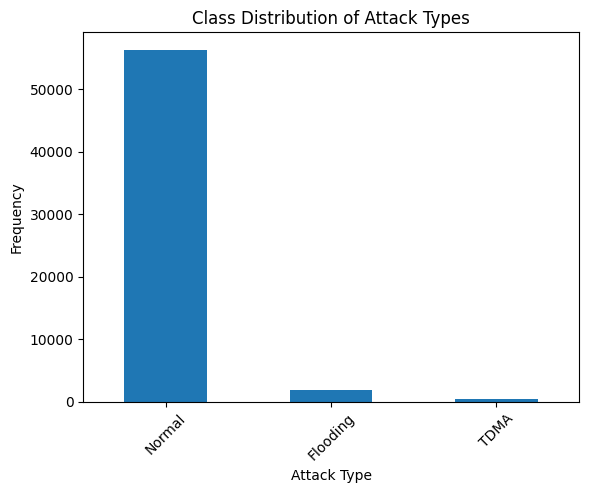

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
file_path = "/content/WSN-DS.csv"
df = pd.read_csv(file_path)
# Checking class distribution of the 'Attack type' column
df['Attack type'].value_counts().plot(kind='bar')
plt.title('Class Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Checking class distribution of the 'Attack type' column
attack_type_counts = df['Attack type'].value_counts()
print(attack_type_counts)

Attack type
Normal      56253
Flooding     1883
TDMA          402
Name: count, dtype: int64


Class Distribution:
3    340066
2     14596
0     10049
4      6638
1      3312
Name: count, dtype: int64
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5498 - loss: 0.6708 - val_accuracy: 0.9678 - val_loss: 0.4532
Epoch 2/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9619 - loss: 0.3281 - val_accuracy: 0.9935 - val_loss: 0.0544
Epoch 3/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9851 - loss: 0.0737 - val_accuracy: 0.9949 - val_loss: 0.0211
Epoch 4/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9869 - loss: 0.0453 - val_accuracy: 0.9949 - val_loss: 0.0172
Epoch 5/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9904 - loss: 0.0354 - val_accuracy: 0.9962 - val_loss: 0.0139
Epoch 6/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9920 - loss: 0.0273 - val_accuracy: 0.9964 - val_loss: 0.0117
Epoch 7/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9927 - loss: 0.0252 - val_accuracy: 0.9967 - val_loss: 0.0103
Epoch 8/15
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9915 - loss: 0.0265 - val_accuracy: 0.9970 - val_

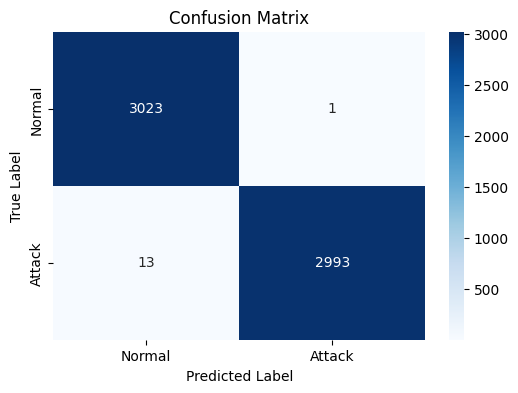

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3024
           1       1.00      1.00      1.00      3006

    accuracy                           1.00      6030
   macro avg       1.00      1.00      1.00      6030
weighted avg       1.00      1.00      1.00      6030



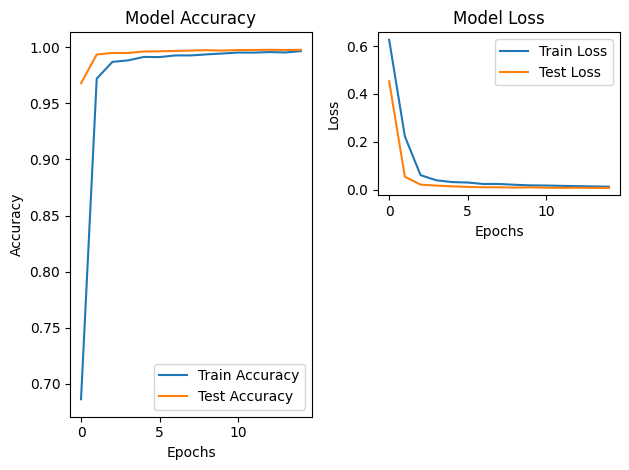

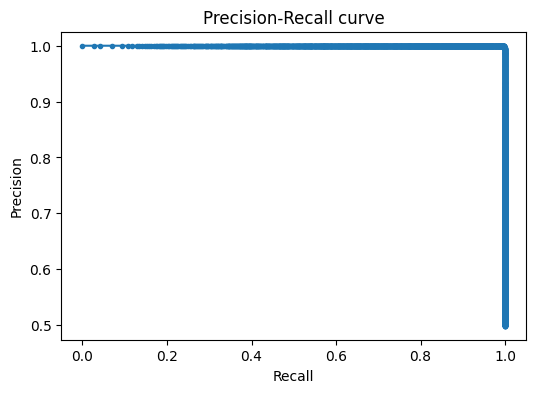

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping

# Load dataset
data = pd.read_csv('/content/WSN-DS.csv')
data.columns = data.columns.str.strip()  # Clean column names

# Separate features (X) and labels (y)
X = data.drop('Attack type', axis=1)
y = data['Attack type']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Replace infinite values and fill NaN values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Check class distribution to understand imbalance
print("Class Distribution:")
print(pd.Series(y).value_counts())

# Select only two classes for binary classification
target_classes = [0, 1]  # Adjust as per your two classes, e.g., 'normal' and 'attack'
y_series = pd.Series(y)  # Convert NumPy array to pandas Series
X_binary = X[y_series.isin(target_classes)]
y_binary = y_series[y_series.isin(target_classes)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_binary)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)  # Increasing k_neighbors for better resampling
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_binary)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.9)  # Retain 90% of variance for faster execution
X_pca = pca.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.3, random_state=42)

# Reshape the data for LSTM (samples, time steps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the optimized CNN-LSTM model for binary classification
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification with sigmoid activation

# Compile the model with adjusted parameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=15, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Threshold for binary classification

# Calculate accuracy and F1 score
f1 = f1_score(y_test, y_pred) * 100

accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100  # Convert to percentage
f1 = f1_score(y_test, y_pred) * 100

# Print accuracy and F1 score
print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix for Binary Classification
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report for detailed binary classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label='Model')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
